In [1]:
# -*- coding: UTF-8 -*-
import json
import jieba
import codecs
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import normalize
from sklearn.externals import joblib
import re
from scipy.sparse import vstack
from tqdm import tqdm

## 将新闻内容以。划分，取包含 company_name 的句子，构成训练文本数据

In [4]:
data = {}
with open('../data/coreEntityEmotion_train.txt', encoding='utf-8') as f:
    for l in tqdm(f):
        a = json.loads(l.strip())
        item = {}
        item['content'] = a['title'] + '。' + a['content']
        
        temp = {}
        for c in a['coreEntityEmotions']:
            temp[c['entity']] = c['emotion']
        item['coreEntityEmotions'] = temp
        
        data[a['newsId']] = item

40000it [00:02, 16901.38it/s]


In [5]:
with codecs.open('../output/train_data.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, indent=4, ensure_ascii=False)

In [6]:
f = codecs.open('../output/train_data.json', 'r', encoding='utf-8')
data = json.load(f)

In [11]:
def filter_text(text):
    re_tag0 = re.compile('</?\w+[^>]*>')  # HTML标签
    re_tag1 = re.compile(r'http://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',re.S)
    re_tag2 = re.compile(r'https://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',re.S)
    re_tag3 = re.compile('(?<=\>).*?(?=\<)')
    re_tag4 = re.compile('购买链接')
    re_tag5 = re.compile('京东：')
    re_tag6 = re.compile('淘宝：')
    re_tag7 = re.compile(r'\d.*?w|\d.*?v|\d.*?a|\d.*?亿元|\d.*?元|\d.*?plus')
    new_text = re.sub(re_tag0,"",text)
    new_text = re.sub(re_tag1,"",new_text)
    new_text = re.sub(re_tag2,"",new_text)
    new_text = re.sub(re_tag3,"",new_text)
    new_text = re.sub(re_tag4,"",new_text)
    new_text = re.sub(re_tag5,"",new_text)
    new_text = re.sub(re_tag6,"",new_text)
    new_text = re.sub(re_tag7, "", new_text)
    new_text = re.sub("-+", "-", new_text)  # 合并-
    new_text = re.sub("———+", "——", new_text)  # 合并-
    return new_text

In [20]:
def make_data(read_data, save_data, save_data2):
    """
    第2步：
    将新闻内容以。划分，取包含 company_name 的句子，构成训练文本数据
    :param read_data:           读入数据
    :param save_data:           保存可以训练的数据（通过主体是否再句子中，取出句子不为空的数据） 2warning_sentence.csv
    :param save_data2:          保存bad数据  2warning_sen_bad.csv
    :param save_data3:          保存通过主体是否再句子中，但取出句子为空的数据 2warning_sen_none.csv
    :return:
    """
    with codecs.open(read_data, 'r', 'utf-8') as f, open(save_data, 'w') as wf, open(save_data2, 'w') as wf2:
        num = 0              # 计数，成功写入
        bad = 0              # 计数，失败
        data = json.load(f)
        for newsId, item in data.items():
            text = item['content']              # 存放训练数据
            content_list = text.split('。')     # 以。划分句子
            entity_list = item['coreEntityEmotions']
            for entity,emotion in entity_list.items(): #3d，工业，机器视觉
                try:
                    content = ''
                    for sentence in content_list:
                        # 如果文中名字（manual_ori_company）在该句子中
                        sentence = filter_text(sentence)
                        sentence = sentence.replace('\n', '')
                        if entity in sentence:
                            if len(sentence) < 300:
                                # 将文本数据中的英文符号 : ' "  转换成 中文符号 ：‘”   另外\ 转换成\\ 防止解析json出错
                                sentence = sentence.replace(':', '：').replace('\'', '‘') \
                                .replace('\"', '“').replace('\\', '\\\\')
                            else:
                                # 找到主体所在句子的位置
                                index = sentence.find(entity)
                                end = index + len(entity) + 80
                                sentence = sentence[index:end]
                             # 不让。出现在content1的首位置
                            if content == '':
                                content = sentence
                            else:
                                content = content + '。' + sentence
                            # 判断取出的content是否为空
                            if len(content) == 0:
                                continue
                            else:
                                wf.write(newsId + '\t' + content + '\t' + entity + '\t' + emotion + '\n')
                                num += 1
#                                 print('\n num:', num)
                except:
                    import traceback
                    bad += 1
                    print(key)
                    wf2.write(newsId + '\t' + text + '\t' + entity + '\t' + emotion + '\n')
                    print(traceback.format_exc())
                    print('bad:', bad)

In [21]:
read_data = '../output/train_data.json'
save_data = '../output/entity_sentence.csv'
save_data2 = '../output/entity_bad_sentence.csv'
make_data(read_data, save_data, save_data2)

## 构造训练数据

In [1]:
import os
import csv
import time
import datetime
import random
import json

import warnings
from collections import Counter
from math import sqrt

import gensim
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
warnings.filterwarnings("ignore")

In [2]:
small_data = '../output/small_data.csv'

In [32]:
with open(save_data, 'r', encoding='utf-8') as rf, open(small_data, 'w', encoding='utf-8') as wf:
    num = 0   # count
    for line in rf:
        line = line.strip('\n')
        if num < 10000:
            wf.write(line + '\n')
            num += 1

In [55]:
df = pd.read_csv(small_data, sep='\t', names=['newsId', 'content','entity', 'emotion'])
df.tail()

,newsId,content,entity,emotion
9995,574c9492,自《阿丽塔：战斗天使》上映以来，就备受网友们的关注，因为这是卡梅隆自《阿凡达》之后的又一部特...,阿丽塔,NEG
9996,574c9492,自《阿丽塔：战斗天使》上映以来，就备受网友们的关注，因为这是卡梅隆自《阿凡达》之后的又一部特...,阿丽塔,NEG
9997,574c9492,自《阿丽塔：战斗天使》上映以来，就备受网友们的关注，因为这是卡梅隆自《阿凡达》之后的又一部特...,阿丽塔,NEG
9998,574c9492,自《阿丽塔：战斗天使》上映以来，就备受网友们的关注，因为这是卡梅隆自《阿凡达》之后的又一部特...,阿丽塔,NEG
9999,574c9492,日票房不足100万，卡梅隆尽力了，他已经跌下神坛,卡梅隆,NEG


In [4]:
df.describe()

,newsId,content,entity,emotion
count,10000,10000,10000,10000
unique,527,9181,1203,3
top,d6cb209a,jennie出席香奈儿秀场连衣裙秀身材，这腰谁扛得住,美国,POS
freq,186,3,143,4890


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
newsId     10000 non-null object
content    10000 non-null object
entity     10000 non-null object
emotion    10000 non-null object
dtypes: object(4)
memory usage: 312.6+ KB


In [6]:
def label_dic(label):
    if label == 'POS':
        return 1
    elif label == 'NORM':
        return 0
    elif label == 'NEG':
        return -1

In [56]:
def label_dic(label):
    if label == 'POS':
        return 1
    elif label == 'NORM':
        return 0
    elif label == 'NEG':
        return -1
df["emotion"] = df["emotion"].apply(label_dic)

In [57]:
df.tail(10)

,newsId,content,entity,emotion
9990,ff011e44,近日，《elle·3月》封面曝光，贾静雯担纲入镜，照片中的她大玩搞怪风之余，还大谈中年女性心...,elle·3月,1
9991,574c9492,自《阿丽塔：战斗天使》上映以来，就备受网友们的关注，因为这是卡梅隆自《阿凡达》之后的又一部特...,阿丽塔,-1
9992,574c9492,自《阿丽塔：战斗天使》上映以来，就备受网友们的关注，因为这是卡梅隆自《阿凡达》之后的又一部特...,阿丽塔,-1
9993,574c9492,自《阿丽塔：战斗天使》上映以来，就备受网友们的关注，因为这是卡梅隆自《阿凡达》之后的又一部特...,阿丽塔,-1
9994,574c9492,自《阿丽塔：战斗天使》上映以来，就备受网友们的关注，因为这是卡梅隆自《阿凡达》之后的又一部特...,阿丽塔,-1
9995,574c9492,自《阿丽塔：战斗天使》上映以来，就备受网友们的关注，因为这是卡梅隆自《阿凡达》之后的又一部特...,阿丽塔,-1
9996,574c9492,自《阿丽塔：战斗天使》上映以来，就备受网友们的关注，因为这是卡梅隆自《阿凡达》之后的又一部特...,阿丽塔,-1
9997,574c9492,自《阿丽塔：战斗天使》上映以来，就备受网友们的关注，因为这是卡梅隆自《阿凡达》之后的又一部特...,阿丽塔,-1
9998,574c9492,自《阿丽塔：战斗天使》上映以来，就备受网友们的关注，因为这是卡梅隆自《阿凡达》之后的又一部特...,阿丽塔,-1
9999,574c9492,日票房不足100万，卡梅隆尽力了，他已经跌下神坛,卡梅隆,-1


In [10]:
df.to_csv("../output/train_df.csv", index=False, sep='\t')

In [159]:
review = df["content"].tolist()
review[0:2]

['无论是展会规模、展示范围以及专业观众的人数，都实现了快速的增长，极大地推动了我国制造业的转型升级和跨越发展！誉洋3d机器视觉引发展会参观热潮在大连誉洋工业智能的展位，机器人自动抓取物件让人眼前一亮',
 '无论是展会规模、展示范围以及专业观众的人数，都实现了快速的增长，极大地推动了我国制造业的转型升级和跨越发展！誉洋3d机器视觉引发展会参观热潮在大连誉洋工业智能的展位，机器人自动抓取物件让人眼前一亮。机器人在3d视觉的引导下精准定位杂乱无序的目标，并实现准确快速抓取，整个过程井然有序，无需任何人工干预']

In [58]:
labels = df["emotion"].tolist()

In [59]:
labels[0:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [67]:
lengths = [len(x) for x in review]
lengths[0:10]

[98, 150, 224, 260, 333, 424, 44, 126, 225, 298]

In [68]:
len(lengths)

10000

In [96]:
lengths = sorted(lengths, key=lambda x: x, reverse=True)
lengths = np.array(lengths)
lengths[0:200]

array([5596, 5525, 5491, 5450, 5402, 5305, 5225, 5111, 5069, 5032, 4966,
       4928, 4819, 4714, 4645, 4617, 4582, 4567, 4507, 4441, 4403, 4373,
       4334, 4303, 4236, 4198, 4138, 4098, 4057, 4016, 3992, 3946, 3911,
       3859, 3846, 3809, 3756, 3722, 3697, 3687, 3673, 3665, 3629, 3619,
       3617, 3568, 3550, 3545, 3531, 3527, 3515, 3471, 3452, 3441, 3440,
       3427, 3422, 3402, 3391, 3357, 3354, 3352, 3331, 3313, 3307, 3282,
       3268, 3256, 3228, 3201, 3197, 3190, 3185, 3176, 3158, 3153, 3139,
       3126, 3111, 3110, 3102, 3068, 3030, 3025, 3024, 2997, 2988, 2977,
       2976, 2973, 2956, 2951, 2950, 2946, 2945, 2939, 2923, 2912, 2912,
       2888, 2886, 2882, 2875, 2854, 2854, 2854, 2853, 2833, 2814, 2810,
       2808, 2796, 2781, 2780, 2772, 2762, 2760, 2752, 2750, 2743, 2735,
       2734, 2731, 2728, 2721, 2715, 2709, 2698, 2696, 2689, 2674, 2658,
       2656, 2652, 2647, 2642, 2632, 2628, 2626, 2615, 2611, 2600, 2598,
       2598, 2596, 2590, 2571, 2565, 2560, 2559, 25

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
df_test = df.copy()

In [213]:
def cut_len(x):
    if len(x)<=1500:
        return 1500
    elif len(x)>1500 and len(x)<=2000:
        return 2000
    elif len(x)>2000 and len(x)<=3000:
        return 3000
    else:
        return 4000

In [214]:
df_test1 = df.copy()
df_test1["len"] = df_test1["content"].apply(cut_len)

In [215]:
df_test1.head()

,newsId,content,entity,emotion,len
0,4e36d02a,无论是展会规模、展示范围以及专业观众的人数，都实现了快速的增长，极大地推动了我国制造业的转型...,3d,1,1500
1,4e36d02a,无论是展会规模、展示范围以及专业观众的人数，都实现了快速的增长，极大地推动了我国制造业的转型...,3d,1,1500
2,4e36d02a,无论是展会规模、展示范围以及专业观众的人数，都实现了快速的增长，极大地推动了我国制造业的转型...,3d,1,1500
3,4e36d02a,无论是展会规模、展示范围以及专业观众的人数，都实现了快速的增长，极大地推动了我国制造业的转型...,3d,1,1500
4,4e36d02a,无论是展会规模、展示范围以及专业观众的人数，都实现了快速的增长，极大地推动了我国制造业的转型...,3d,1,1500


In [94]:
#  Number of words in the text ##
df_test["len"] = df_test["content"].apply(lambda x: len(x))

In [95]:
df_test.describe([0.01,0.1,0.25,.5,.75,.85,.90,.95,.99])

,emotion,len
count,10000.00000,10000.000000
mean,0.34470,475.256200
std,0.71731,586.948842
min,-1.00000,5.000000
1%,-1.00000,17.000000
10%,-1.00000,42.000000
25%,0.00000,122.000000
50%,0.00000,282.000000
75%,1.00000,587.000000
85%,1.00000,868.000000


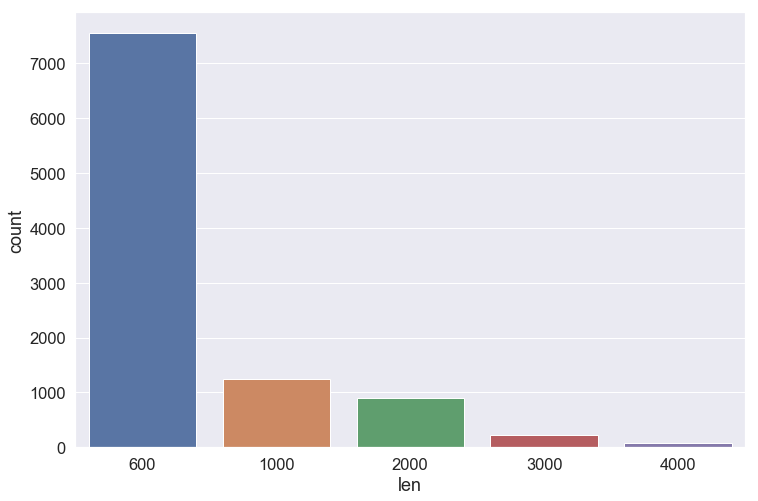

In [115]:
plt.figure(figsize=(12, 8))
sns.countplot(x='len', data=df_test1)

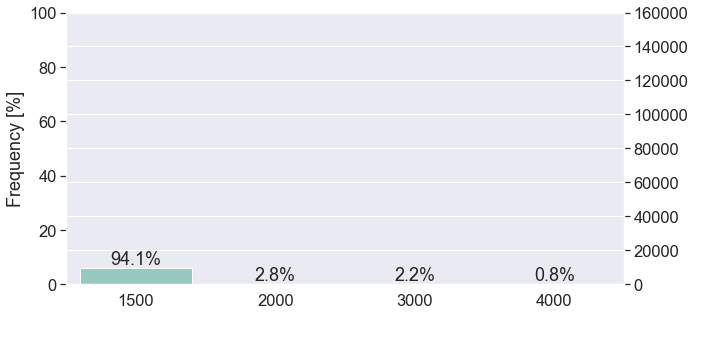

In [216]:
def add_freq(data):
    ncount = len(data)

    ax2=ax.twinx()

    ax2.yaxis.tick_left()
    ax.yaxis.tick_right()

    ax.yaxis.set_label_position('right')
    ax2.yaxis.set_label_position('left')

    ax2.set_ylabel('Frequency [%]')

    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom')

    ax2.set_ylim(0,100)
    ax2.grid(None)
    
ax = sns.countplot(x = df_test1.len ,palette="Set3")
sns.set(font_scale=1.5)
ax.set_ylim(top = 150000)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(10,5)
ax.set_ylim(top=160000)

add_freq(df_test1)

plt.show()

In [14]:
# 配置参数

class TrainingConfig(object):
    epoches = 10
    evaluateEvery = 100
    checkpointEvery = 100
    learningRate = 0.001
    
    
class ModelConfig(object):
    embeddingSize = 200
    
    filters = 128  # 内层一维卷积核的数量，外层卷积核的数量应该等于embeddingSize，因为要确保每个layer后的输出维度和输入维度是一致的。
    numHeads = 8  # Attention 的头数
    numBlocks = 1  # 设置transformer block的数量
    epsilon = 1e-8  # LayerNorm 层中的最小除数
    keepProp = 0.9  # multi head attention 中的dropout
    
    dropoutKeepProb = 0.5 # 全连接层的dropout
    l2RegLambda = 0.0
    
    
class Config(object):
    sequenceLength = 1500  # 取了所有序列长度的均值
    batchSize = 128
    
    dataSource = "../output/train_df.csv"
    
    numClasses = 2
    
    rate = 0.8  # 训练集的比例
    
    training = TrainingConfig()
    
    model = ModelConfig()

    
# 实例化配置参数对象
config = Config()

In [21]:
# 数据预处理的类，生成训练集和测试集

class Dataset(object):
    def __init__(self, config):
        self._dataSource = config.dataSource
        
        self._sequenceLength = config.sequenceLength  # 每条输入的序列处理为定长
        self._embeddingSize = config.model.embeddingSize
        self._batchSize = config.batchSize
        self._rate = config.rate
        
        self.trainReviews = []
        self.trainLabels = []
        
        self.evalReviews = []
        self.evalLabels = []
        
        self.wordEmbedding =None
        
        self._wordToIndex = {}
        self._indexToWord = {}
        
    def _readData(self, filePath):
        """
        从csv文件中读取数据集
        """
        
        df = pd.read_csv(filePath, sep='\t', names=['newsId', 'content','entity', 'emotion'])
        review = df["content"].tolist()
        
        def label_dic(label):
            if label == 'POS':
                return 1
            elif label == 'NORM':
                return 0
            elif label == 'NEG':
                return -1
            
        df["emotion"] = df["emotion"].apply(label_dic)
        labels = df["emotion"].tolist()
        
        import jieba
        files = os.listdir('../字典')
        for file_name in files:
            jieba.load_userdict('../字典/' + file_name)
        jieba.load_userdict('../runs/entity.txt')

        stop_words = []
        with open('../data/stop_words.txt', 'r', encoding='utf-8') as f:
            lines = f.readlines()
            for line in lines:
                line = line.replace("\n", "")
                stop_words.append(line)

        all_docs = []
        i = 0
        for data in review:
            words = jieba.cut(data)
            words = filter(lambda x: x not in stop_words, words)
            all_docs.append(list(words))
            if i % 500 == 0:
                print(i, ' data finish')
            i += 1

        return all_docs, labels

    def _reviewProcess(self, review, sequenceLength, wordToIndex):
        """
        将数据集中的每条评论用index表示
        wordToIndex中“pad”对应的index为0
        """
        
        reviewVec = np.zeros((sequenceLength))
        sequenceLen = sequenceLength
        
        # 判断当前的序列是否小于定义的固定序列长度
        if len(review) < sequenceLength:
            sequenceLen = len(review)
            
        for i in range(sequenceLen):
            if review[i] in wordToIndex:
                reviewVec[i] = wordToIndex[review[i]]
            else:
                reviewVec[i] = wordToIndex["UNK"]

        return reviewVec

    def _genTrainEvalData(self, x, y, rate):
        """
        生成训练集和验证集
        """
        
        reviews = []
        labels = []
        
        # 遍历所有的文本，将文本中的词转换成index表示
        for i in range(len(x)):
            reviewVec = self._reviewProcess(x[i], self._sequenceLength, self._wordToIndex)
            reviews.append(reviewVec)
            
            labels.append([y[i]])
            
        trainIndex = int(len(x) * rate)
        
        trainReviews = np.asarray(reviews[:trainIndex], dtype="int64")
        trainLabels = np.array(labels[:trainIndex], dtype="float32")
        
        evalReviews = np.asarray(reviews[trainIndex:], dtype="int64")
        evalLabels = np.array(labels[trainIndex:], dtype="float32")

        return trainReviews, trainLabels, evalReviews, evalLabels
        
    def _genVocabulary(self, reviews):
        """
        生成词向量和词汇-索引映射字典，可以用全数据集
        """
        
        allWords = [word for review in reviews for word in review]
        
        wordCount = Counter(allWords)  # 统计词频
        sortWordCount = sorted(wordCount.items(), key=lambda x: x[1], reverse=True)
        
        # 去除低频词
        words = [item[0] for item in sortWordCount if item[1] >= 2]
        
        vocab, wordEmbedding = self._getWordEmbedding(words)
        self.wordEmbedding = wordEmbedding
        
        self._wordToIndex = dict(zip(vocab, list(range(len(vocab)))))
        self._indexToWord = dict(zip(list(range(len(vocab))), vocab))
        
        # 将词汇-索引映射表保存为json数据，之后做inference时直接加载来处理数据
        with open("../output/wordToIndex.json", "w", encoding="utf-8") as f:
            json.dump(self._wordToIndex, f)
        
        with open("../output/indexToWord.json", "w", encoding="utf-8") as f:
            json.dump(self._indexToWord, f)
            
    def _getWordEmbedding(self, words):
        """
        按照我们的数据集中的单词取出预训练好的word2vec中的词向量
        """
        from gensim.models import FastText
        wordVec = FastText.load('../runs/fasttext_model')
        vocab = []
        wordEmbedding = []
        
        # 添加 "pad" 和 "UNK", 
        vocab.append("pad")
        vocab.append("UNK")
        wordEmbedding.append(np.zeros(self._embeddingSize))
        wordEmbedding.append(np.random.randn(self._embeddingSize))
        
        for word in words:
            try:
                vector = wordVec.wv[word]
                vocab.append(word)
                wordEmbedding.append(vector)
            except:
                print(word + "不存在于词向量中")
                
        return vocab, np.array(wordEmbedding)
            
    def dataGen(self):
        """
        初始化训练集和验证集
        """
        # 初始化数据集
        reviews, labels = self._readData(self._dataSource)
        
        # 初始化词汇-索引映射表和词向量矩阵
        self._genVocabulary(reviews)
        
        # 初始化训练集和测试集
        trainReviews, trainLabels, evalReviews, evalLabels = self._genTrainEvalData(reviews, labels, self._rate)
        self.trainReviews = trainReviews
        self.trainLabels = trainLabels
        
        self.evalReviews = evalReviews
        self.evalLabels = evalLabels
        
data = Dataset(config)
data.dataGen()

0  data finish
500  data finish
1000  data finish
1500  data finish
2000  data finish
2500  data finish
3000  data finish
3500  data finish
4000  data finish
4500  data finish
5000  data finish
5500  data finish
6000  data finish
6500  data finish
7000  data finish
7500  data finish
8000  data finish
8500  data finish
9000  data finish
9500  data finish
10000  data finish
连过不存在于词向量中
指为不存在于词向量中
已向不存在于词向量中
看完不存在于词向量中
应属不存在于词向量中
改出不存在于词向量中
较快不存在于词向量中
着名不存在于词向量中
种得不存在于词向量中
大场不存在于词向量中
很美不存在于词向量中
后端不存在于词向量中
仍以不存在于词向量中
官全不存在于词向量中
回中不存在于词向量中
赶去不存在于词向量中
归到不存在于词向量中
理出不存在于词向量中
之举不存在于词向量中
为直不存在于词向量中
听清不存在于词向量中
起至不存在于词向量中
拿起不存在于词向量中
自股不存在于词向量中
熟到不存在于词向量中
体用不存在于词向量中
解了不存在于词向量中
特在不存在于词向量中
没给不存在于词向量中
中韩不存在于词向量中
党心不存在于词向量中
其钱不存在于词向量中
小场不存在于词向量中
亚都不存在于词向量中
首月不存在于词向量中
想靠不存在于词向量中
听完不存在于词向量中
所讲不存在于词向量中
这季不存在于词向量中
流到不存在于词向量中
收得不存在于词向量中
vh不存在于词向量中
一划不存在于词向量中
设于不存在于词向量中
做分不存在于词向量中
所应不存在于词向量中
抢得不存在于词向量中
坐得不存在于词向量中
拍去不存在于词向量中
所具不存在于词向量中
合起不存在于词向量中
没数不存在于词向量中


In [83]:
data.wordEmbedding.shape

(23526, 200)

In [84]:
word_embedding = pd.DataFrame(data.wordEmbedding)
word_embedding.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,-0.772068,1.923703,1.379893,0.483076,0.826718,-0.062425,0.289548,0.457742,0.640200,-0.876724,...,-0.426017,-1.258112,-0.547281,-0.609702,-0.957129,0.066992,1.802548,-0.343936,0.228859,0.889228
2,-0.390790,-0.929125,-2.371427,-1.126142,-0.232861,-0.555668,0.060788,-2.067189,0.708972,1.869089,...,1.769296,0.607791,1.685267,0.462870,1.235561,2.705509,-3.699732,0.136413,1.322007,0.485764
3,-0.256993,-0.627401,-0.376660,-0.145329,-0.640091,-0.257066,-0.007209,0.066371,-0.923578,0.741953,...,0.378577,-0.465361,0.712872,-0.108740,0.223569,0.042677,-1.303379,-0.874297,0.215704,-0.256057
4,0.778642,-0.788620,0.440488,0.910248,0.421461,0.251527,0.307918,-0.429128,-0.015830,2.231030,...,-0.868681,0.239313,0.347212,-0.594535,0.660311,0.547517,-0.272696,-0.192027,-0.037123,-1.403011


In [85]:
word_embedding.to_csv("../output/word_embedding.csv", index=False, sep='\t')

In [22]:
print("train data shape: {}".format(data.trainReviews.shape))
print("train label shape: {}".format(data.trainLabels.shape))
print("eval data shape: {}".format(data.evalReviews.shape))

train data shape: (8000, 1500)
train label shape: (8000, 1)
eval data shape: (2001, 1500)


In [52]:
df.head()

,newsId,content,entity,emotion
0,4e36d02a,无论是展会规模、展示范围以及专业观众的人数，都实现了快速的增长，极大地推动了我国制造业的转型...,3d,None
1,4e36d02a,无论是展会规模、展示范围以及专业观众的人数，都实现了快速的增长，极大地推动了我国制造业的转型...,3d,None
2,4e36d02a,无论是展会规模、展示范围以及专业观众的人数，都实现了快速的增长，极大地推动了我国制造业的转型...,3d,None
3,4e36d02a,无论是展会规模、展示范围以及专业观众的人数，都实现了快速的增长，极大地推动了我国制造业的转型...,3d,None
4,4e36d02a,无论是展会规模、展示范围以及专业观众的人数，都实现了快速的增长，极大地推动了我国制造业的转型...,3d,None


In [60]:
labels

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [69]:
trainIndex = 8000

# trainReviews = np.asarray(reviews[:trainIndex], dtype="int64")
trainLabels = np.array(labels[:trainIndex], dtype="float32")

# evalReviews = np.asarray(reviews[trainIndex:], dtype="int64")

In [70]:
trainLabels.shape

(8000,)

In [36]:
len(data.trainReviews[0])

1500

In [47]:
data.trainLabels[0:10]

array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]], dtype=float32)

In [71]:
trainLabels = pd.DataFrame(trainLabels)
trainLabels.head()

,0
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [73]:
evalLabels = np.array(labels[trainIndex:], dtype="float32")
evalLabels

array([ 1.,  1.,  1., ..., -1., -1., -1.], dtype=float32)

In [75]:
evalLabels.shape

(2000, 1)

In [74]:
evalLabels = pd.DataFrame(evalLabels)
evalLabels.head()

,0
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [76]:
evalLabels.to_csv("../output/eval_labels.csv", index=False, sep='\t')

In [72]:
trainLabels.to_csv("../output/train_labels.csv", index=False, sep='\t')

In [42]:
evalReviews = pd.DataFrame(data.evalReviews)
evalReviews.head()

,0,1,2,3,4,5,6,7,8,9,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
0,3973,964,13388,1560,223,964,8171,517,3262,223,...,0,0,0,0,0,0,0,0,0,0
1,3973,964,13388,1560,223,964,8171,517,3262,223,...,0,0,0,0,0,0,0,0,0,0
2,3973,964,13388,1560,223,964,8171,517,3262,223,...,0,0,0,0,0,0,0,0,0,0
3,3973,964,13388,1560,223,964,8171,517,3262,223,...,0,0,0,0,0,0,0,0,0,0
4,3973,964,13388,1560,223,964,8171,517,3262,223,...,0,0,0,0,0,0,0,0,0,0


In [45]:
evalReviews.to_csv("../output/eval_num.csv", index=False, sep='\t')

In [37]:
trainReviews = pd.DataFrame(data.trainReviews)
trainReviews.head()

,0,1,2,3,4,5,6,7,8,9,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
0,413,337,738,14100,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,879,3779,151,549,336,865,1447,185,73,225,...,0,0,0,0,0,0,0,0,0,0
2,879,3779,151,549,336,865,1447,185,73,225,...,0,0,0,0,0,0,0,0,0,0
3,879,3779,151,549,336,865,1447,185,73,225,...,0,0,0,0,0,0,0,0,0,0
4,879,3779,151,549,336,865,1447,185,73,225,...,0,0,0,0,0,0,0,0,0,0


In [77]:
df = pd.read_csv("../output/train_num.csv", sep='\t')
df.tail()

,0,1,2,3,4,5,6,7,8,9,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
7995,3097,7527,7932,16088,64,1915,18026,278,3097,7527,...,0,0,0,0,0,0,0,0,0,0
7996,3973,964,13388,1560,223,964,8171,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7997,3973,964,13388,1560,223,964,8171,517,3262,223,...,0,0,0,0,0,0,0,0,0,0
7998,3973,964,13388,1560,223,964,8171,517,3262,223,...,0,0,0,0,0,0,0,0,0,0
7999,3973,964,13388,1560,223,964,8171,517,3262,223,...,0,0,0,0,0,0,0,0,0,0


In [79]:
train_data = np.asarray(df)
len(train_data[0])

1500

In [44]:
trainReviews.to_csv("../output/train_num.csv", index=False, sep='\t')

In [98]:
content = df_test["content"].tolist()
content[0:5]

['无论是展会规模、展示范围以及专业观众的人数，都实现了快速的增长，极大地推动了我国制造业的转型升级和跨越发展！誉洋3d机器视觉引发展会参观热潮在大连誉洋工业智能的展位，机器人自动抓取物件让人眼前一亮',
 '无论是展会规模、展示范围以及专业观众的人数，都实现了快速的增长，极大地推动了我国制造业的转型升级和跨越发展！誉洋3d机器视觉引发展会参观热潮在大连誉洋工业智能的展位，机器人自动抓取物件让人眼前一亮。机器人在3d视觉的引导下精准定位杂乱无序的目标，并实现准确快速抓取，整个过程井然有序，无需任何人工干预',
 '无论是展会规模、展示范围以及专业观众的人数，都实现了快速的增长，极大地推动了我国制造业的转型升级和跨越发展！誉洋3d机器视觉引发展会参观热潮在大连誉洋工业智能的展位，机器人自动抓取物件让人眼前一亮。机器人在3d视觉的引导下精准定位杂乱无序的目标，并实现准确快速抓取，整个过程井然有序，无需任何人工干预。誉洋现场工程师介绍，制造企业采用誉洋kineye®3d机器视觉系统，以往繁琐、枯燥的物料搬运工作交给了机器人，这样不但解放了人力，还提升了物流效率',
 '无论是展会规模、展示范围以及专业观众的人数，都实现了快速的增长，极大地推动了我国制造业的转型升级和跨越发展！誉洋3d机器视觉引发展会参观热潮在大连誉洋工业智能的展位，机器人自动抓取物件让人眼前一亮。机器人在3d视觉的引导下精准定位杂乱无序的目标，并实现准确快速抓取，整个过程井然有序，无需任何人工干预。誉洋现场工程师介绍，制造企业采用誉洋kineye®3d机器视觉系统，以往繁琐、枯燥的物料搬运工作交给了机器人，这样不但解放了人力，还提升了物流效率。这套3d机器视觉已在国内多家知名企业成功实施应用，得到了一致认可与好评',
 '无论是展会规模、展示范围以及专业观众的人数，都实现了快速的增长，极大地推动了我国制造业的转型升级和跨越发展！誉洋3d机器视觉引发展会参观热潮在大连誉洋工业智能的展位，机器人自动抓取物件让人眼前一亮。机器人在3d视觉的引导下精准定位杂乱无序的目标，并实现准确快速抓取，整个过程井然有序，无需任何人工干预。誉洋现场工程师介绍，制造企业采用誉洋kineye®3d机器视觉系统，以往繁琐、枯燥的物料搬运工作交给了机器人，这样不但解放了人力，还提升了物流效率。这套3d机器视觉已在国内多家知名企业成功实

In [160]:
labels = df["emotion"].tolist()

In [99]:
len(content)

10000

In [105]:
import jieba
files = os.listdir('../字典')
for file_name in files:
    jieba.load_userdict('../字典/' + file_name)
jieba.load_userdict('../runs/entity.txt')

stop_words = []
with open('../data/stop_words.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()
    for line in lines:
        line = line.replace("\n", "")
        stop_words.append(line)

In [140]:
all_docs = []
i = 0
for data in content:
    words = jieba.cut(data)
    words = filter(lambda x: x not in stop_words, words)
    all_docs.append(list(words))
    if i % 500 == 0:
        print(i, ' data finish')
    i += 1

0  data finish
500  data finish
1000  data finish
1500  data finish
2000  data finish
2500  data finish
3000  data finish
3500  data finish
4000  data finish
4500  data finish
5000  data finish
5500  data finish
6000  data finish
6500  data finish
7000  data finish
7500  data finish
8000  data finish
8500  data finish
9000  data finish
9500  data finish


In [141]:
allWords = [word for doc in all_docs for word in doc]
len(allWords)  # 573w

1420331

In [143]:
wordCount = Counter(allWords)  # 统计词频
len(wordCount) # 16w

24802

In [144]:
sortWordCount = sorted(wordCount.items(), key=lambda x: x[1], reverse=True)
sortWordCount[0:10], len(sortWordCount)

([('年', 12783),
  ('微信', 11677),
  ('中', 9189),
  ('市场', 6875),
  ('月', 5972),
  ('发展', 5609),
  ('产品', 5169),
  ('腾讯', 4979),
  ('20', 4181),
  ('企业', 4165)],
 24802)

In [147]:
# 去除低频词
words = [item[0] for item in sortWordCount if item[1] >= 2]
len(words) # 3w

23518

In [148]:
words[0:10]

['年', '微信', '中', '市场', '月', '发展', '产品', '腾讯', '20', '企业']

In [149]:
df_test["content"] = all_docs

In [150]:
df_test.head()

,newsId,content,entity,emotion,len
0,4e36d02a,"[无论是, 展会, 规模, 展示, 专业, 观众, 人数, 快速, 增长, 推动, 我国, ...",3d,1,98
1,4e36d02a,"[无论是, 展会, 规模, 展示, 专业, 观众, 人数, 快速, 增长, 推动, 我国, ...",3d,1,150
2,4e36d02a,"[无论是, 展会, 规模, 展示, 专业, 观众, 人数, 快速, 增长, 推动, 我国, ...",3d,1,224
3,4e36d02a,"[无论是, 展会, 规模, 展示, 专业, 观众, 人数, 快速, 增长, 推动, 我国, ...",3d,1,260
4,4e36d02a,"[无论是, 展会, 规模, 展示, 专业, 观众, 人数, 快速, 增长, 推动, 我国, ...",3d,1,333


In [151]:
def _getWordEmbedding(words, embeddingSize=200):
    """
    按照我们的数据集中的单词取出预训练好的word2vec中的词向量
    """
    from gensim.models import FastText
    wordVec = FastText.load('../runs/fasttext_model')
    vocab = []
    wordEmbedding = []

    # 添加 "pad" 和 "UNK", 
    vocab.append("pad")
    vocab.append("UNK")
    wordEmbedding.append(np.zeros(embeddingSize))
    wordEmbedding.append(np.random.randn(embeddingSize))

    for word in words:
        try:
            vector = wordVec.wv[word] # 每个词200维
            vocab.append(word)  # 词表
            wordEmbedding.append(vector) # 词向量
        except:
            print(word + "不存在于词向量中")

    return vocab, np.array(wordEmbedding)

In [152]:
vocab, wordEmbedding = _getWordEmbedding(words)

看完不存在于词向量中
应属不存在于词向量中
改出不存在于词向量中
较快不存在于词向量中
后端不存在于词向量中
赶去不存在于词向量中
理出不存在于词向量中
之举不存在于词向量中
听清不存在于词向量中
自股不存在于词向量中
熟到不存在于词向量中
体用不存在于词向量中
中韩不存在于词向量中
党心不存在于词向量中
其钱不存在于词向量中
小场不存在于词向量中
亚都不存在于词向量中
首月不存在于词向量中
想靠不存在于词向量中
听完不存在于词向量中
所讲不存在于词向量中
收得不存在于词向量中
vh不存在于词向量中
一划不存在于词向量中
做分不存在于词向量中
抢得不存在于词向量中
拍去不存在于词向量中
没数不存在于词向量中


In [217]:
len(vocab),len(wordEmbedding)

(23492, 23492)

In [218]:
wordEmbedding[2].shape

(200,)

In [219]:
wordToIndex = dict(zip(vocab, list(range(len(vocab)))))
indexToWord = dict(zip(list(range(len(vocab))), vocab))

In [220]:
wordToIndex

{'pad': 0,
 'UNK': 1,
 '年': 2,
 '微信': 3,
 '中': 4,
 '市场': 5,
 '月': 6,
 '发展': 7,
 '产品': 8,
 '腾讯': 9,
 '20': 10,
 '企业': 11,
 '公司': 12,
 '美国': 13,
 '日': 14,
 '券商': 15,
 '新': 16,
 '减值': 17,
 '用户': 18,
 '业务': 19,
 '中国': 20,
 '我国': 21,
 '2018': 22,
 '时': 23,
 '国债期货': 24,
 '数据': 25,
 'ar': 26,
 '行业': 27,
 '占': 28,
 '平台': 29,
 '技术': 30,
 '投资': 31,
 '农业': 32,
 '信托': 33,
 '切削': 34,
 '15': 35,
 '包括': 36,
 '做': 37,
 '2019': 38,
 '服务': 39,
 '说': 40,
 '影响': 41,
 '牛市': 42,
 '高': 43,
 '投资者': 44,
 '提供': 45,
 '模式': 46,
 '独角兽': 47,
 '券商股': 48,
 '实验室': 49,
 '全球': 50,
 '17': 51,
 '国债': 52,
 '建设': 53,
 '前': 54,
 '华为': 55,
 '工业': 56,
 '融资': 57,
 '资产': 58,
 '方式': 59,
 '10': 60,
 '刀具': 61,
 '生态': 62,
 '领域': 63,
 '品牌': 64,
 ' ': 65,
 '机构': 66,
 'shell': 67,
 '女性': 68,
 '支持': 69,
 '生产': 70,
 '互联网': 71,
 '参与': 72,
 '增长': 73,
 '金融': 74,
 '快手': 75,
 '发布': 76,
 '变化': 77,
 '提升': 78,
 '工作': 79,
 '情况': 80,
 '风险': 81,
 '项目': 82,
 '网络': 83,
 '持续': 84,
 '收益': 85,
 '农民工': 86,
 '时间': 87,
 '25': 88,
 '功能': 89,
 '12': 90,
 '循环

In [221]:
def reviewProcess(review, sequenceLength, wordToIndex):
    """
    将数据集中的每条评论用index表示
    wordToIndex中“pad”对应的index为0
    """

    reviewVec = np.zeros((sequenceLength)) # 生成一个长度为1500的list
    sequenceLen = sequenceLength  # 1500

    # 判断当前的序列是否小于定义的固定序列长度
    if len(review) < sequenceLength:
        sequenceLen = len(review)

    for i in range(sequenceLen): # 将每句话中的词用word id表示
        if review[i] in wordToIndex:
            reviewVec[i] = wordToIndex[review[i]]
        else:
            reviewVec[i] = wordToIndex["UNK"] # 没有在word词典中用 UNK 表示

    return reviewVec

In [222]:
content_ = []
labels_ = []

# 遍历所有的文本，将文本中的词转换成index表示
for i in range(len(content)):
    reviewVec = reviewProcess(content[i], 1500, wordToIndex)
    content_.append(reviewVec)
    labels_.append([labels[i]])

In [223]:
len(labels_)

10000

In [224]:
content_[10][20]

1420.0

In [225]:
len(content_[0]), len(content_)

(1500, 10000)

In [226]:
def genTrainEvalData(x, y, sequenceLength, wordToIndex, rate):
    """
    生成训练集和验证集
    """

    reviews = []
    labels = []

    # 遍历所有的文本，将文本中的词转换成index表示
    for i in range(len(x)):
        reviewVec = reviewProcess(x[i], sequenceLength, wordToIndex)
        reviews.append(reviewVec)
        labels.append([y[i]])

    trainIndex = int(len(x) * rate)

    trainReviews = np.asarray(reviews[:trainIndex], dtype="int64")
    trainLabels = np.array(labels[:trainIndex], dtype="float32")

    evalReviews = np.asarray(reviews[trainIndex:], dtype="int64")
    evalLabels = np.array(labels[trainIndex:], dtype="float32")

    return trainReviews, trainLabels, evalReviews, evalLabels

In [227]:
trainReviews, trainLabels, evalReviews, evalLabels = genTrainEvalData(content, labels, 1500, wordToIndex, 0.8)

In [228]:
trainReviews.shape, evalReviews.shape

((8000, 1500), (2000, 1500))

In [229]:
trainReviews[0]

array([1, 1, 1, ..., 0, 0, 0])

In [230]:
trainLabels.shape, evalLabels.shape

((8000, 1), (2000, 1))

In [231]:
trainReviews[0][0:20]

array([    1,     1,     1, 13234,     1,     1,     1,     1, 13234,
           1,     1,     1,     1,     1,  5663, 22576, 12565,  5288,
           1,     1])

In [232]:
# 输出batch数据集

def nextBatch(x, y, batchSize):
        """
        生成batch数据集，用生成器的方式输出
        """
    
        perm = np.arange(len(x))
        np.random.shuffle(perm)
        x = x[perm]
        y = y[perm]
        
        numBatches = len(x) // batchSize

        for i in range(numBatches):
            start = i * batchSize
            end = start + batchSize
            batchX = np.array(x[start: end], dtype="int64")
            batchY = np.array(y[start: end], dtype="float32")
            
            yield batchX, batchY

In [259]:
# 生成位置嵌入
def fixedPositionEmbedding(batchSize, sequenceLen):
    embeddedPosition = []
    for batch in range(batchSize): # 128
        x = []
        # [1., 0., 0., ..., 0., 0., 0.]
        # [0., 1., 0., ..., 0., 0., 0.]
        for step in range(sequenceLen): # 1500
            a = np.zeros(sequenceLen) # (1500,)
            a[step] = 1
            x.append(a)
        embeddedPosition.append(x)
    
    return np.array(embeddedPosition, dtype="float32")

In [260]:
embeddedPosition = fixedPositionEmbedding(128, 1500)
embeddedPosition[0]

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [261]:
embeddedPosition.shape

(128, 1500, 1500)

In [268]:
# 配置参数

class TrainingConfig(object):
    epoches = 10
    evaluateEvery = 100
    checkpointEvery = 100
    learningRate = 0.001
    
    
class ModelConfig(object):
    embeddingSize = 200
    filters = 128  # 内层一维卷积核的数量，外层卷积核的数量应该等于embeddingSize，因为要确保每个layer后的输出维度和输入维度是一致的。
    numHeads = 8  # Attention 的头数
    numBlocks = 1  # 设置transformer block的数量
    epsilon = 1e-8  # LayerNorm 层中的最小除数
    keepProp = 0.9  # multi head attention 中的dropout
    dropoutKeepProb = 0.5 # 全连接层的dropout
    l2RegLambda = 0.0
    
    
class Config(object):
    embeddingSize = 200
    sequenceLength = 1500  # 取了所有序列长度的均值
    batchSize = 128
    
    dataSource = "../data/preProcess/labeledTrain.csv"
    
    stopWordSource = "../data/english"
    
    numClasses = 2
    
    rate = 0.8  # 训练集的比例
    
    training = TrainingConfig()
    
    model = ModelConfig()

    
# 实例化配置参数对象
config = Config()

In [262]:
# 模型构建
class Transformer(object):
    """
    Transformer Encoder 用于文本分类
    """
    def __init__(self, config, wordEmbedding):

        # 定义模型的输入
        # [?, 1500]
        self.inputX = tf.placeholder(tf.int32, [None, config.sequenceLength], name="inputX")
        # [?, 1]
        self.inputY = tf.placeholder(tf.float32, [None, 1], name="inputY")
        
        self.dropoutKeepProb = tf.placeholder(tf.float32, name="dropoutKeepProb")
        # [?, 1500, 200]
#         self.embeddedPosition = tf.placeholder(tf.float32, [None, config.sequenceLength, config.embeddingSize], name="embeddedPosition")
        
        self.config = config
        
        # 定义l2损失
        l2Loss = tf.constant(0.0)
        
        # 词嵌入层, 位置向量的定义方式有两种：一是直接用固定的one-hot的形式传入，然后和词向量拼接，在当前的数据集上表现效果更好。另一种
        # 就是按照论文中的方法实现，这样的效果反而更差，可能是增大了模型的复杂度，在小数据集上表现不佳。
        
#         with tf.name_scope("embedding"):

#             # 利用预训练的词向量初始化词嵌入矩阵
#             # [?, 200]
#             self.W = tf.Variable(tf.cast(wordEmbedding, dtype=tf.float32, name="word2vec") ,name="W")
#             # 利用词嵌入矩阵将输入的数据中的词转换成词向量，维度[batch_size, sequence_length, embedding_size]
#             # [?, 1500, 200]  [?, 1500] [?, 200]
#             self.embedded = tf.nn.embedding_lookup(self.W, self.inputX)
#             # embedding
#             # positionEmbedding [?, 1500, 1500]
#             self.embeddedWords = tf.concat([self.embedded, self.embeddedPosition], -1)

#         with tf.name_scope("transformer"):
#             for i in range(config.model.numBlocks):
#                 with tf.name_scope("transformer-{}".format(i + 1)):
            
#                     # 维度[batch_size, sequence_length, embedding_size]
#                     multiHeadAtt = self._multiheadAttention(rawKeys=self.embedded, queries=self.embeddedWords,
#                                                             keys=self.embeddedWords)
#                     # 维度[batch_size, sequence_length, embedding_size]
#                     self.embeddedWords = self._feedForward(multiHeadAtt, 
#                                                            [config.model.filters, config.model.embeddingSize + config.sequenceLength])
                
#             outputs = tf.reshape(self.embeddedWords, [-1, config.sequenceLength * (config.model.embeddingSize + config.sequenceLength)])

#         outputSize = outputs.get_shape()[-1].value

        with tf.name_scope("wordEmbedding"):
            self.W = tf.Variable(tf.cast(wordEmbedding, dtype=tf.float32, name="word2vec"), name="W")
            self.wordEmbedded = tf.nn.embedding_lookup(self.W, self.inputX)
        
        with tf.name_scope("positionEmbedding"):
            print(self.wordEmbedded)
            self.positionEmbedded = self._positionEmbedding()
            
        self.embeddedWords = self.wordEmbedded + self.positionEmbedded
            
        with tf.name_scope("transformer"):
            for i in range(config.model.numBlocks):
                with tf.name_scope("transformer-{}".format(i + 1)):
            
                    # 维度[batch_size, sequence_length, embedding_size]
                    multiHeadAtt = self._multiheadAttention(rawKeys=self.wordEmbedded, queries=self.embeddedWords,
                                                            keys=self.embeddedWords)
                    # 维度[batch_size, sequence_length, embedding_size]
                    self.embeddedWords = self._feedForward(multiHeadAtt, [config.model.filters, config.model.embeddingSize])
                
            outputs = tf.reshape(self.embeddedWords, [-1, config.sequenceLength * (config.model.embeddingSize)])

        outputSize = outputs.get_shape()[-1].value
        
        with tf.name_scope("dropout"):
            outputs = tf.nn.dropout(outputs, keep_prob=self.dropoutKeepProb)
    
        # 全连接层的输出
        with tf.name_scope("output"):
            outputW = tf.get_variable(
                "outputW",
                shape=[outputSize, 1],
                initializer=tf.contrib.layers.xavier_initializer())
            
            outputB= tf.Variable(tf.constant(0.1, shape=[1]), name="outputB")
            l2Loss += tf.nn.l2_loss(outputW)
            l2Loss += tf.nn.l2_loss(outputB)
            self.predictions = tf.nn.xw_plus_b(outputs, outputW, outputB, name="predictions")
            self.binaryPreds = tf.cast(tf.greater_equal(self.predictions, 0.5), tf.float32, name="binaryPreds")
        
        # 计算二元交叉熵损失
        with tf.name_scope("loss"):
            
            losses = tf.nn.sigmoid_cross_entropy_with_logits(logits=self.predictions, labels=self.inputY)
            self.loss = tf.reduce_mean(losses) + config.model.l2RegLambda * l2Loss
            
    def _layerNormalization(self, inputs, scope="layerNorm"):
        # LayerNorm层和BN层有所不同
        epsilon = self.config.model.epsilon

        inputsShape = inputs.get_shape() # [batch_size, sequence_length, embedding_size]

        paramsShape = inputsShape[-1:]

        # LayerNorm是在最后的维度上计算输入的数据的均值和方差，BN层是考虑所有维度的
        # mean, variance的维度都是[batch_size, sequence_len, 1]
        mean, variance = tf.nn.moments(inputs, [-1], keep_dims=True)

        beta = tf.Variable(tf.zeros(paramsShape))

        gamma = tf.Variable(tf.ones(paramsShape))
        normalized = (inputs - mean) / ((variance + epsilon) ** .5)
        
        outputs = gamma * normalized + beta

        return outputs
    # rawKeys=self.embedded, queries=self.embeddedWords, keys=self.embeddedWords        
    def _multiheadAttention(self, rawKeys, queries, keys, numUnits=None, causality=False, scope="multiheadAttention"):
        # rawKeys 的作用是为了计算mask时用的，因为keys是加上了position embedding的，其中不存在padding为0的值
        
        numHeads = self.config.model.numHeads # 8
        keepProp = self.config.model.keepProp
        
        if numUnits is None:  # 若是没传入值，直接去输入数据的最后一维，即embedding size.
            numUnits = queries.get_shape().as_list()[-1]

        # tf.layers.dense可以做多维tensor数据的非线性映射，在计算self-Attention时，一定要对这三个值进行非线性映射，
        # 其实这一步就是论文中Multi-Head Attention中的对分割后的数据进行权重映射的步骤，我们在这里先映射后分割，原则上是一样的。
        # Q, K, V的维度都是[batch_size, sequence_length, embedding_size]
        Q = tf.layers.dense(queries, numUnits, activation=tf.nn.relu)
        K = tf.layers.dense(keys, numUnits, activation=tf.nn.relu)
        V = tf.layers.dense(keys, numUnits, activation=tf.nn.relu)

        # 将数据按最后一维分割成num_heads个, 然后按照第一维拼接
        # Q, K, V 的维度都是[batch_size * numHeads, sequence_length, embedding_size/numHeads]
        Q_ = tf.concat(tf.split(Q, numHeads, axis=-1), axis=0) 
        K_ = tf.concat(tf.split(K, numHeads, axis=-1), axis=0) 
        V_ = tf.concat(tf.split(V, numHeads, axis=-1), axis=0)

        # 计算keys和queries之间的点积，维度[batch_size * numHeads, queries_len, key_len], 后两维是queries和keys的序列长度
        similary = tf.matmul(Q_, tf.transpose(K_, [0, 2, 1]))

        # 对计算的点积进行缩放处理，除以向量长度的根号值
        scaledSimilary = similary / (K_.get_shape().as_list()[-1] ** 0.5)

        # 在我们输入的序列中会存在padding这个样的填充词，这种词应该对最终的结果是毫无帮助的，原则上说当padding都是输入0时，
        # 计算出来的权重应该也是0，但是在transformer中引入了位置向量，当和位置向量相加之后，其值就不为0了，因此在添加位置向量
        # 之前，我们需要将其mask为0。虽然在queries中也存在这样的填充词，但原则上模型的结果之和输入有关，而且在self-Attention中
        # queryies = keys，因此只要一方为0，计算出的权重就为0。
        # 具体关于key mask的介绍可以看看这里： https://github.com/Kyubyong/transformer/issues/3
        
#         因为训练时基本是使用mini batch的方式，这就需要对token数量较少的sequence用<PAD>在尾部填充使得batch里的每个句子长度相同
#         在Encoder环节去除<PAD>对句子中其他token的影响是在Scaled Dot-Product 结束后紧跟一个mask操作（
#         即对<PAD>的score减去一个极大值---e.g. 1E+9，使得softmax输出的<PAD>token的相关性系数接近 0）

#         对于没有<PAD>填充的句子则Mask操作就可以忽略，所以Mask操作是optional的

#         笔者个人感性理解Encoder里的mask操作：即保证<PAD>token在提炼过程中：
#         <PAD>不会对其他token向量的信息提炼产生影响
#         对<PAD>向量再怎么信息提炼还是<PAD>向量

        # 将每一时序上的向量中的值相加取平均值
        keyMasks = tf.sign(tf.abs(tf.reduce_sum(rawKeys, axis=-1)))  # 维度[batch_size, time_step]

        # 利用tf，tile进行张量扩张， 维度[batch_size * numHeads, keys_len] keys_len = keys 的序列长度
        keyMasks = tf.tile(keyMasks, [numHeads, 1]) 

        # 增加一个维度，并进行扩张，得到维度[batch_size * numHeads, queries_len, keys_len]
        keyMasks = tf.tile(tf.expand_dims(keyMasks, 1), [1, tf.shape(queries)[1], 1])

        # tf.ones_like生成元素全为1，维度和scaledSimilary相同的tensor, 然后得到负无穷大的值
        paddings = tf.ones_like(scaledSimilary) * (-2 ** (32 + 1))

        # tf.where(condition, x, y),condition中的元素为bool值，其中对应的True用x中的元素替换，对应的False用y中的元素替换
        # 因此condition,x,y的维度是一样的。下面就是keyMasks中的值为0就用paddings中的值替换
        maskedSimilary = tf.where(tf.equal(keyMasks, 0), paddings, scaledSimilary) # 维度[batch_size * numHeads, queries_len, key_len]

        # 在计算当前的词时，只考虑上文，不考虑下文，出现在Transformer Decoder中。在文本分类时，可以只用Transformer Encoder。
        # Decoder是生成模型，主要用在语言生成中
        if causality:
            diagVals = tf.ones_like(maskedSimilary[0, :, :])  # [queries_len, keys_len]
            tril = tf.contrib.linalg.LinearOperatorTriL(diagVals).to_dense()  # [queries_len, keys_len]
            masks = tf.tile(tf.expand_dims(tril, 0), [tf.shape(maskedSimilary)[0], 1, 1])  # [batch_size * numHeads, queries_len, keys_len]

            paddings = tf.ones_like(masks) * (-2 ** (32 + 1))
            maskedSimilary = tf.where(tf.equal(masks, 0), paddings, maskedSimilary)  # [batch_size * numHeads, queries_len, keys_len]

        # 通过softmax计算权重系数，维度 [batch_size * numHeads, queries_len, keys_len]
        weights = tf.nn.softmax(maskedSimilary)

        # 加权和得到输出值, 维度[batch_size * numHeads, sequence_length, embedding_size/numHeads]
        outputs = tf.matmul(weights, V_)

        # 将多头Attention计算的得到的输出重组成最初的维度[batch_size, sequence_length, embedding_size]
        outputs = tf.concat(tf.split(outputs, numHeads, axis=0), axis=2)
        
        outputs = tf.nn.dropout(outputs, keep_prob=keepProp)

        # 对每个subLayers建立残差连接，即H(x) = F(x) + x
        outputs += queries
        # normalization 层
        outputs = self._layerNormalization(outputs)
        return outputs

    # multiHeadAtt, [config.model.filters, config.model.embeddingSize]
    def _feedForward(self, inputs, filters, scope="multiheadAttention"):
        # 在这里的前向传播采用卷积神经网络
        
        # 内层
        params = {"inputs": inputs, "filters": filters[0], "kernel_size": 1,
                  "activation": tf.nn.relu, "use_bias": True}
        outputs = tf.layers.conv1d(**params)

        # 外层
        params = {"inputs": outputs, "filters": filters[1], "kernel_size": 1,
                  "activation": None, "use_bias": True}

        # 这里用到了一维卷积，实际上卷积核尺寸还是二维的，只是只需要指定高度，宽度和embedding size的尺寸一致
        # 维度[batch_size, sequence_length, embedding_size]
        outputs = tf.layers.conv1d(**params)

        # 残差连接
        outputs += inputs

        # 归一化处理
        outputs = self._layerNormalization(outputs)

        return outputs
    
    def _positionEmbedding(self, scope="positionEmbedding"):
        # 生成可训练的位置向量
        batchSize = self.config.batchSize
        sequenceLen = self.config.sequenceLength
        embeddingSize = self.config.model.embeddingSize
        
        # 生成位置的索引，并扩张到batch中所有的样本上
        positionIndex = tf.tile(tf.expand_dims(tf.range(sequenceLen), 0), [batchSize, 1])
        
        # 根据正弦和余弦函数来获得每个位置上的embedding的第一部分
        positionEmbedding = np.array([[pos / np.power(10000, (i-i%2) / embeddingSize) for i in range(embeddingSize)] 
                                      for pos in range(sequenceLen)])

        # 然后根据奇偶性分别用sin和cos函数来包装
        positionEmbedding[:, 0::2] = np.sin(positionEmbedding[:, 0::2])
        positionEmbedding[:, 1::2] = np.cos(positionEmbedding[:, 1::2])

        # 将positionEmbedding转换成tensor的格式
        positionEmbedding_ = tf.cast(positionEmbedding, dtype=tf.float32)

        # 得到三维的矩阵[batchSize, sequenceLen, embeddingSize]
        positionEmbedded = tf.nn.embedding_lookup(positionEmbedding_, positionIndex)

        return positionEmbedded

In [264]:
def _positionEmbedding(config):
    # 生成可训练的位置向量
    batchSize = config.batchSize
    sequenceLen = config.sequenceLength
    embeddingSize = config.model.embeddingSize

    # 生成位置的索引，并扩张到batch中所有的样本上
    positionIndex = tf.tile(tf.expand_dims(tf.range(sequenceLen), 0), [batchSize, 1])

    # 根据正弦和余弦函数来获得每个位置上的embedding的第一部分
    positionEmbedding = np.array([[pos / np.power(10000, (i-i%2) / embeddingSize) for i in range(embeddingSize)] 
                                  for pos in range(sequenceLen)])

    # 然后根据奇偶性分别用sin和cos函数来包装
    positionEmbedding[:, 0::2] = np.sin(positionEmbedding[:, 0::2])
    positionEmbedding[:, 1::2] = np.cos(positionEmbedding[:, 1::2])

    # 将positionEmbedding转换成tensor的格式
    positionEmbedding_ = tf.cast(positionEmbedding, dtype=tf.float32)

    # 得到三维的矩阵[batchSize, sequenceLen, embeddingSize]
    positionEmbedded = tf.nn.embedding_lookup(positionEmbedding_, positionIndex)

    return positionEmbedded

In [238]:
# 定义性能指标函数

def mean(item):
    return sum(item) / len(item)


def genMetrics(trueY, predY, binaryPredY):
    """
    生成acc和auc值
    """
    auc = roc_auc_score(trueY, predY)
    accuracy = accuracy_score(trueY, binaryPredY)
    precision = precision_score(trueY, binaryPredY)
    recall = recall_score(trueY, binaryPredY)
    
    return round(accuracy, 4), round(auc, 4), round(precision, 4), round(recall, 4)

In [269]:
positionEmbedded = _positionEmbedding(config)
positionEmbedded.shape

TensorShape([Dimension(128), Dimension(1500), Dimension(200)])

In [ ]:
# 训练模型

# 生成训练集和验证集
# trainReviews = data.trainReviews
# trainLabels = data.trainLabels
# evalReviews = data.evalReviews
# evalLabels = data.evalLabels

# wordEmbedding = data.wordEmbedding

# positionEmbedded = _positionEmbedding(config)

# 定义计算图
with tf.Graph().as_default():

    session_conf = tf.ConfigProto(allow_soft_placement=True, log_device_placement=False)
    session_conf.gpu_options.allow_growth=True
    session_conf.gpu_options.per_process_gpu_memory_fraction = 0.9  # 配置gpu占用率  

    sess = tf.Session(config=session_conf)
    
    # 定义会话
    with sess.as_default():
        transformer = Transformer(config, wordEmbedding)
        
        globalStep = tf.Variable(0, name="globalStep", trainable=False)
        # 定义优化函数，传入学习速率参数
        optimizer = tf.train.AdamOptimizer(config.training.learningRate)
        # 计算梯度,得到梯度和变量
        gradsAndVars = optimizer.compute_gradients(transformer.loss)
        # 将梯度应用到变量下，生成训练器
        trainOp = optimizer.apply_gradients(gradsAndVars, global_step=globalStep)
        
        # 用summary绘制tensorBoard
        gradSummaries = []
        for g, v in gradsAndVars:
            if g is not None:
                tf.summary.histogram("{}/grad/hist".format(v.name), g)
                tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
        
        outDir = os.path.abspath(os.path.join(os.path.curdir, "summarys"))
        print("Writing to {}\n".format(outDir))
        
        lossSummary = tf.summary.scalar("loss", transformer.loss)
        summaryOp = tf.summary.merge_all()
        
        trainSummaryDir = os.path.join(outDir, "train")
        trainSummaryWriter = tf.summary.FileWriter(trainSummaryDir, sess.graph)
        
        evalSummaryDir = os.path.join(outDir, "eval")
        evalSummaryWriter = tf.summary.FileWriter(evalSummaryDir, sess.graph)
        
        
        # 初始化所有变量
        saver = tf.train.Saver(tf.global_variables(), max_to_keep=5)
        
        # 保存模型的一种方式，保存为pb文件
#         builder = tf.saved_model.builder.SavedModelBuilder("../model/Transformer/savedModel")
        sess.run(tf.global_variables_initializer())

        def trainStep(batchX, batchY):
            """
            训练函数
            """   
            feed_dict = {
              transformer.inputX: batchX,
              transformer.inputY: batchY,
              transformer.dropoutKeepProb: config.model.dropoutKeepProb
            }
            _, summary, step, loss, predictions, binaryPreds = sess.run(
                [trainOp, summaryOp, globalStep, transformer.loss, transformer.predictions, transformer.binaryPreds],
                feed_dict)
            timeStr = datetime.datetime.now().isoformat()
            acc,es = []
            accs = []
            aucs = []
            precisions = []
            recalls = []

            for batchEval in nextBatch(evalReviews, evalLabels, config.batchSize):
                loss, acc, auc, precision, recall = devStep(batchEval[0], batchEval[1])
                losses.append(loss)
                accs.append(acc)
                aucs.append(auc)
                precisions.append(precision)
                recalls.append(recall)

            time_str = datetime.datetime.now().isoformat()
            print("{}, step: {}, loss: {}, acc: {}, auc: {}, precision: {}, recall: {}".format(time_str, currentStep, mean(losses), 
                                                                                               mean(accs), mean(aucs), mean(precisions),
                                                                                               mean(recalls)))

            if currentStep % config.training.checkpointEvery == 0:
                # 保存模型的另一种方法，保存checkpoint文件
                path = saver.save(sess, "../model/Transformer/model/my-model", global_step=currentStep)
                print("Saved model checkpoint to {}\n".format(path))

            auc, precision, recall = genMetrics(batchY, predictions, binaryPreds)
            print("{}, step: {}, loss: {}, acc: {}, auc: {}, precision: {}, recall: {}".format(timeStr, step, loss, acc, auc, precision, recall))
            trainSummaryWriter.add_summary(summary, step)

    def devStep(batchX, batchY):
        """
        验证函数
        """
        feed_dict = {
          transformer.inputX: batchX,
          transformer.inputY: batchY,
          transformer.dropoutKeepProb: 1.0
        }
        summary, step, loss, predictions, binaryPreds = sess.run(
            [summaryOp, globalStep, transformer.loss, transformer.predictions, transformer.binaryPreds],
            feed_dict)

        acc, auc, precision, recall = genMetrics(batchY, predictions, binaryPreds)

        evalSummaryWriter.add_summary(summary, step)

        return loss, acc, auc, precision, recall

    for i in range(config.training.epoches):
        # 训练模型
        print("start training model")
        for batchTrain in nextBatch(trainReviews, trainLabels, config.batchSize):
            trainStep(batchTrain[0], batchTrain[1])

            currentStep = tf.train.global_step(sess, globalStep) 
            if currentStep % config.training.evaluateEvery == 0:
                print("\n Evaluation:")

                lossinputs = {"inputX": tf.saved_model.utils.build_tensor_info(transformer.inputX),
                  "keepProb": tf.saved_model.utils.build_tensor_info(transformer.dropoutKeepProb)}

        outputs = {"binaryPreds": tf.saved_model.utils.build_tensor_info(transformer.binaryPreds)}

        prediction_signature = tf.saved_model.signature_def_utils.build_signature_def(inputs=inputs, outputs=outputs,
                                                                                      method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME)
        legacy_init_op = tf.group(tf.tables_initializer(), name="legacy_init_op")
        builder.add_meta_graph_and_variables(sess, [tf.saved_model.tag_constants.SERVING],
                                            signature_def_map={"predict": prediction_signature}, legacy_init_op=legacy_init_op)

        builder.save()

Tensor("wordEmbedding/embedding_lookup/Identity:0", shape=(?, 1500, 200), dtype=float32)
INFO:tensorflow:Summary name wordEmbedding/W:0/grad/hist is illegal; using wordEmbedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name wordEmbedding/W:0/grad/sparsity is illegal; using wordEmbedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name dense/kernel:0/grad/hist is illegal; using dense/kernel_0/grad/hist instead.
INFO:tensorflow:Summary name dense/kernel:0/grad/sparsity is illegal; using dense/kernel_0/grad/sparsity instead.
INFO:tensorflow:Summary name dense/bias:0/grad/hist is illegal; using dense/bias_0/grad/hist instead.
INFO:tensorflow:Summary name dense/bias:0/grad/sparsity is illegal; using dense/bias_0/grad/sparsity instead.
INFO:tensorflow:Summary name dense_1/kernel:0/grad/hist is illegal; using dense_1/kernel_0/grad/hist instead.
INFO:tensorflow:Summary name dense_1/kernel:0/grad/sparsity is illegal; using dense_1/kernel_0/grad/sparsity instead.
INFO:tensorflow:Sum